In [1]:
from google.colab import files
uploaded = files.upload()

Saving DataSet.rar to DataSet.rar


In [2]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [3]:
!unrar x DataSet.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from DataSet.rar

Creating    DataSet                                                   OK
Creating    DataSet/Data_cloudy                                       OK
Extracting  DataSet/Data_cloudy/train_10021.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10070.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10096.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_101.jpg                              0%  OK 
Extracting  DataSet/Data_cloudy/train_10128.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10177.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10231.jpg                            0%  OK 
Extracting  DataSet/Data_cloudy/train_10451.jpg                            0%  OK 
Extracting  D

In [8]:
!pip install timm
import timm, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = '/content/DataSet'  # your image folder
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [10]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(out, 1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, preds = torch.max(out, 1)
                correct += (preds == y).sum().item()
                total += y.size(0)
        val_acc = correct / total

        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")
    return history


In [11]:
swin = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=num_classes).to(device)
optimizer = optim.Adam(swin.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
history_swin = train_model(swin, criterion, optimizer, train_loader, val_loader)

Epoch 1: Train Acc=0.9429, Val Acc=0.9852
Epoch 2: Train Acc=0.9762, Val Acc=1.0000
Epoch 3: Train Acc=0.9921, Val Acc=0.9926
Epoch 4: Train Acc=0.9944, Val Acc=0.9963
Epoch 5: Train Acc=0.9944, Val Acc=0.9926


In [12]:
convnext = timm.create_model('convnext_tiny', pretrained=True, num_classes=num_classes).to(device)
optimizer = optim.Adam(convnext.parameters(), lr=1e-4)
history_convnext = train_model(convnext, criterion, optimizer, train_loader, val_loader)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1: Train Acc=0.8341, Val Acc=0.9296
Epoch 2: Train Acc=0.9508, Val Acc=0.9704
Epoch 3: Train Acc=0.9738, Val Acc=0.9778
Epoch 4: Train Acc=0.9873, Val Acc=0.9556
Epoch 5: Train Acc=0.9794, Val Acc=0.9852


                 precision    recall  f1-score   support

    Data_cloudy       1.00      1.00      1.00        77
    Data_desert       1.00      1.00      1.00        79
Data_green_area       1.00      1.00      1.00        82
     Data_water       1.00      1.00      1.00        32

       accuracy                           1.00       270
      macro avg       1.00      1.00      1.00       270
   weighted avg       1.00      1.00      1.00       270



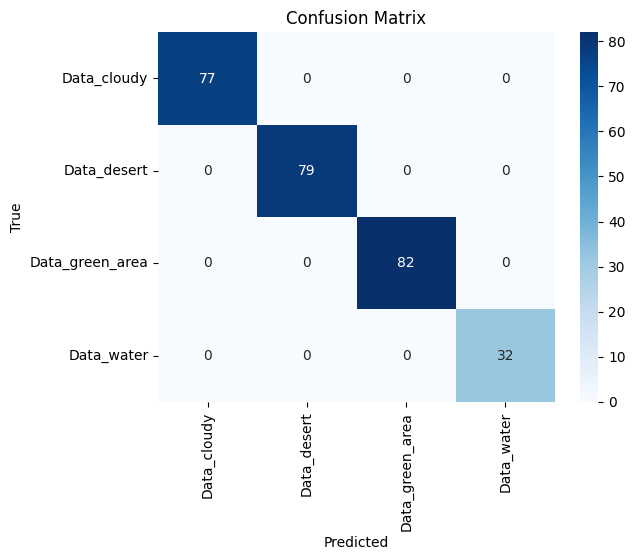

                 precision    recall  f1-score   support

    Data_cloudy       1.00      0.99      0.99        77
    Data_desert       1.00      1.00      1.00        79
Data_green_area       0.99      1.00      0.99        82
     Data_water       0.97      0.97      0.97        32

       accuracy                           0.99       270
      macro avg       0.99      0.99      0.99       270
   weighted avg       0.99      0.99      0.99       270



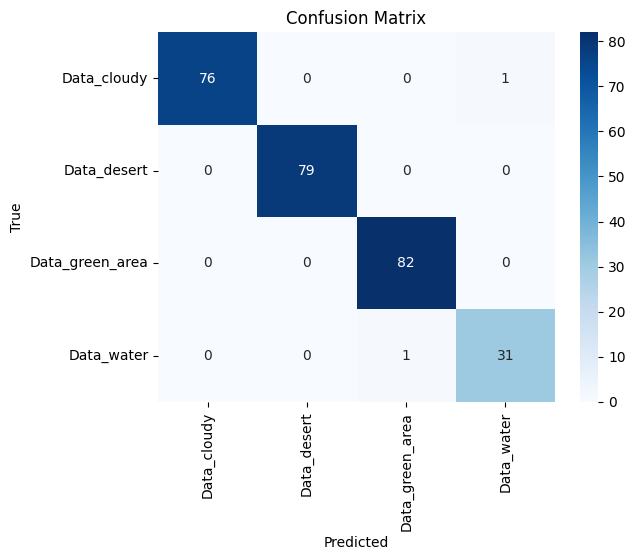

In [13]:
def evaluate(model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate(swin)
evaluate(convnext)
